In [1]:
import itertools as it
import json
import re
import warnings

import dexplot as dxp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.plotly as py
import seaborn as sns
from dfpvizpy.dfpvizpy import dfpSave
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

# Make plotly work with Jupyter notebook
init_notebook_mode(connected=True)

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
sns.set(style="ticks", context='talk')
sns.set_palette('colorblind')

/Users/CSmith/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [31]:
# this is the .json file with all of the questions and coding of the variables
with open('../raw_data/dfp_survey_questions.json', 'r') as fp:
    polling_info = json.load(fp)

In [32]:
other_cols = set(polling_info['misc']['other_cols'])
quant_cols = set(polling_info['misc']['quant_cols'])
unknown_cols = set(polling_info['misc']['unknown_cols'])
agree_order = polling_info['misc']['agree_order']
age_order = polling_info['misc']['age_order']
net_positivity_dict = polling_info['misc']['net_positivity_dict']
state_dict = polling_info['misc']['state_dict']
dict_keys = set(polling_info.keys())

In [37]:
# reading in the data to a dataframe
df = pd.read_csv('../raw_data/DFP_WTHH_release.csv', index_col=0)

# there are two values that need to be moved into the "employ" column
df.loc[2939]['employ'] = 6
df.loc[3110]['employ'] = 9
df.drop(columns='job', inplace=True)
# df.fillna('?', inplace=True)
df['state'] = df['state'].replace('District of Columbia', 11)
df_cols = set(df.columns.tolist())
qual_cols = df_cols - quant_cols - other_cols - unknown_cols

In [38]:
# replace vlaues in qualative answers
for column in qual_cols:
    df[column] = df[column].fillna(999).astype(int).astype(str).replace(
        '999', '?').replace(polling_info[column])
quant_df = df[list(quant_cols)].astype(float)
qual_df = df[list(qual_cols)]

In [44]:
# saving counts to a text file
with open('../raw_data/polling_counts.txt', 'w') as f:
    for column in qual_cols:
            f.write(column + ' | ' + polling_info[column]["question"] + '\n\n')
            f.write("*-" * 35 + '\n\n')
            f.write(qual_df[column].value_counts().to_string())
            f.write('\n\n\n')

In [46]:
# for col in qual_cols:
#     s = sns.catplot(
#         x='age5',
#         kind='count',
#         hue=col,
#         col='gender',
#         data=df,
#         col_wrap=2,
#         height=6,
#         aspect=2,
#         legend=False,
#         order=list(polling_info['age5'].values())[:-1])
#     # s.ax.set_ylabel('Number of Respondents')
#     # s.ax.set_xlabel('Age')
#     # s.ax.set_title(polling_info['FLAG']['question'])
#     s.axes[1].legend(frameon=False)
#     s.axes[0].set_title('Female')
#     s.axes[1].set_title('Male')
#     # s.fig.tight_layout()
#     s.fig.suptitle(polling_info[col]['question'].title())
#     s.fig.subplots_adjust(top=0.8)
#     dfpSave(f'../figures/age_and_{col}.png', s.axes)
# #     plt.show()

In [71]:
def freq_table(x, hue=None, col=None):
    '''

    '''
    tables = []
    x_ind = x[x == '?'].index

    x.drop(x_ind, inplace=True)
    if hue is not None:
        hue.drop(x_ind, inplace=True)
    if col is not None:
        col.drop(x_ind, inplace=True)

    df = pd.get_dummies(x)
    df['Hue'] = hue
    df['Col'] = col

    drp_index = df[(df.Hue == '?') | (df.Col == '?')].index
    df.drop(drp_index, inplace=True)

#     totals = df[x.unique()].sum(axis=0)
#     totals['Total'] = totals.sum()

    for col in df.Col.unique():
        df_col = df[df.Col == col]
        totals = df_col[x.unique()].sum(axis=0)
        totals['Total'] = totals.sum()
    
        grouped = df_col.groupby(by=hue).sum()
        grouped['Total'] = grouped.sum(axis=1)
        num = pd.DataFrame([grouped.sum(axis=0).values],
                           index=['Total'],
                           columns=grouped.sum(axis=0).index)

        x_vals = grouped.columns
        scaled = grouped.copy()

        for x_val in x_vals:
            scaled[x_val] = scaled[x_val] / totals.loc[x_val] * 100

        scaled.index.name = f'{col}'
        tables.append((np.round(scaled, decimals=2), len(df_col)))

    return tables

In [72]:
def freq_df(x, hue=None, col=None):
    col_name = col.name
    hue_name = hue.name
    x_name = x.name

    tbls = freq_table(x, hue=hue, col=col)
    df_list = []
    for dft, N in tbls:
        dft.drop('Total', axis=1, inplace=True)
        te = pd.DataFrame([(x, hue, vals) for (hue, x), vals in zip(
            it.product(dft.index, dft.columns), dft.values.flatten())],
            columns=[x_name, hue_name, 'Percentage'])
        te[col_name] = dft.index.name
        te['Number'] = N
        df_list.append(te)

    df = pd.concat(df_list, ignore_index=True)

    return df, tbls

In [73]:
freq_dfs, freq_tables = freq_df(qual_df.age5, hue=qual_df.gender, col=qual_df.WELTEST)

In [74]:
freq_dfs

,age5,gender,Percentage,WELTEST,Number
0,18-29,Female,54.29,Strongly support,1392
1,30-39,Female,73.68,Strongly support,1392
2,40-49,Female,70.55,Strongly support,1392
3,50-64,Female,61.93,Strongly support,1392
4,65+,Female,40.48,Strongly support,1392
5,18-29,Male,45.71,Strongly support,1392
6,30-39,Male,26.32,Strongly support,1392
7,40-49,Male,29.45,Strongly support,1392
8,50-64,Male,38.07,Strongly support,1392
9,65+,Male,59.52,Strongly support,1392


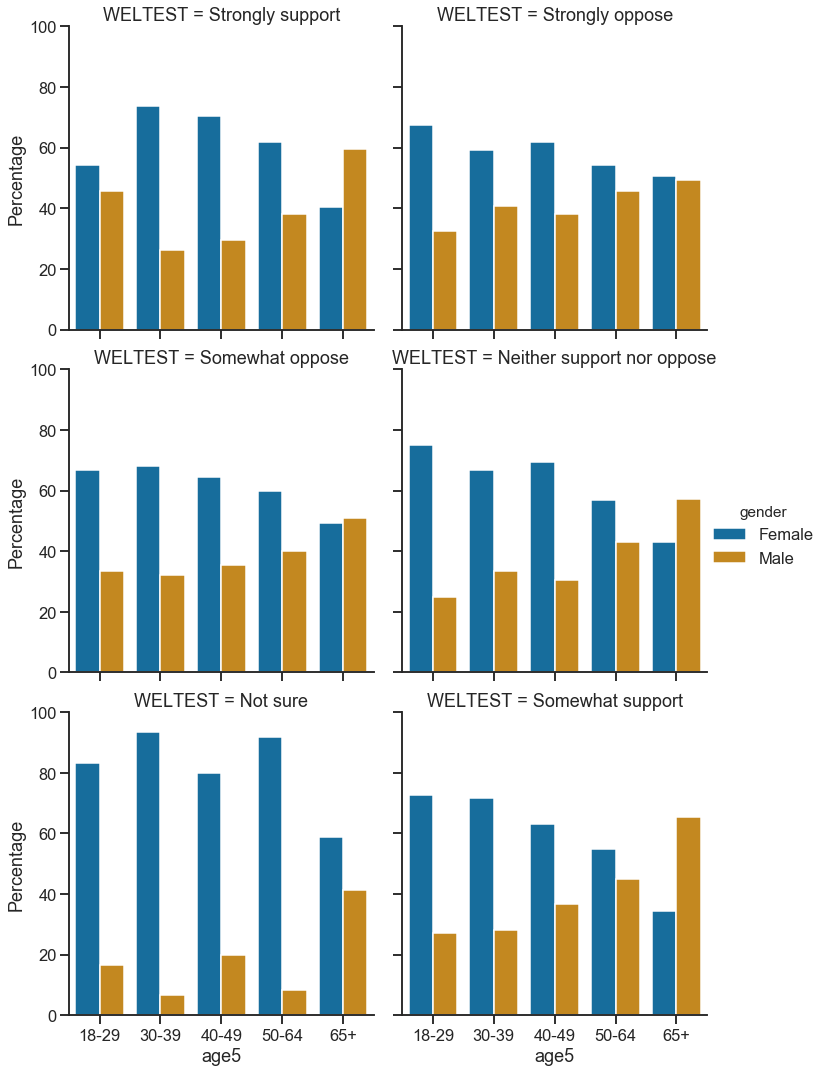

In [76]:
s = sns.catplot(
    x='age5',
    y='Percentage',
    hue='gender', 
    col='WELTEST',
    data=freq_dfs,
    kind='bar',
    col_wrap=2)
for ax in s.axes:
    ax.set_xticklabels(age_order)
    ax.set_ylim([0, 100])
# s.figure.set_figheight(10)
# s.figure.set_figwidth(15)
# s.axes.tick_params(axis='x', rotation=45)
# s.axes.set_xlabel('')

In [47]:
li = []
for age in freq_dfs.Age5.unique():
    sm = freq_dfs[freq_dfs.Age5 == age]
    #     li.append([age,
    li.append([
        age, sm[sm.Remarks == 'Positive']['Percentage'].values[0] -
        sm[sm.Remarks == 'Negative']['Percentage'].values[0]
    ])

AttributeError: 'DataFrame' object has no attribute 'Remarks'

In [48]:
dfc = pd.DataFrame(li, columns=['Age', 'Net Positivity'])
dfc

,Age,Net Positivity


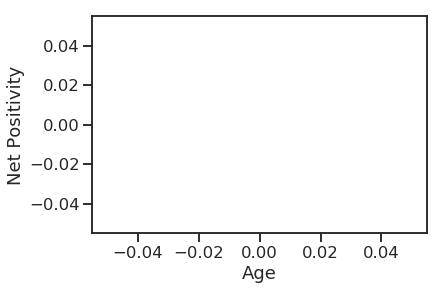

In [49]:
sns.lineplot(x='Age', y='Net Positivity', data=dfc)

In [ ]:
state_dict = {f'{value}': f'{key}' for key, value in state_dict.items()}

In [ ]:
scl = [[0.0, 'rgb(242,240,247)'], [0.2, 'rgb(218,218,235)'], [0.4, 'rgb(188,189,220)'],
       [0.6, 'rgb(158,154,200)'], [0.8, 'rgb(117,107,177)'], [1.0, 'rgb(84,39,143)']]

df['text'] = df['state']
df['z'] = df.Ft_Blacks.replace('?', '0').astype(float) - 50
df['location'] = df.state.replace(state_dict)

data = [
    dict(
        type='choropleth',
        colorscale='YIOrRd',
        autocolorscale=True,
        locations=df.location,
        z=df.z,
        locationmode='USA-states',
        text=df.text,
        marker=dict(line=dict(color='rgb(255,255,255)', width=2)),
        colorbar=dict(title='Trust'))
]

layout = dict(
    title=polling_info['FT_Blacks']['question'],
    geo=dict(
        scope='usa',
        projection=dict(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'),
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map.html')

In [ ]:
print(polling_info['FT_Whites']['question'])

dft = df[['FT_Whites', 'race']]
dft.race = dft['race'].replace('?', 999).astype(int).astype(str).replace(
    '999', '?').replace(polling_info['race'])
dft = dft[dft.FT_Whites != '?']
dft.FT_Whites = dft["FT_Whites"].astype(float)
dfg = dft.groupby(['race']).median()
sort_order = dfg.sort_values(by='FT_Whites', ascending=False).index.tolist()

x_dat = df["race"].replace('?', 999).astype(int).astype(str).replace(
    '999', '?').replace(polling_info['race'])
f, ax = plt.subplots(figsize=(13, 8))
idx = df[df.FT_Blacks != '?']
df_new = idx[idx.FT_Whites != '?']
ax = sns.boxplot(
    y=x_dat, x=df_new["FT_Whites"].astype(float), order=sort_order)
ax.set_ylabel('')
ax.set_title('Feelings Toward White People')
ax.set_xlabel('')
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xticklabels(
    ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
dfpSave('feelings_towards_white_people_by_race.png', [ax])
plt.show()

In [ ]:
table = pd.pivot_table(
    df, index=['Age', 'Party'], columns=['Gender'], aggfunc=np.sum)
display(table)

In [ ]:
for x in table:
    print(x)

In [ ]:
df.Age.head(5)

In [ ]:
for name in np.sort(df.columns):
    print(df[name].head(5))

In [ ]:
list(polling_info['FLAG'].values())

In [ ]:
polling_info['FLAG']['question']

In [ ]:
df['Gender'].value_counts()

In [52]:
df.state.value_counts().sort_index().sum()

3215